بسم الله الرحمن الرحيم

# Data

## Download data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-dataset' dataset.
Path to dataset files: /kaggle/input/face-mask-dataset


## Load data

In [2]:
import os
import pandas as pd

In [3]:
WithMaskPath = "/kaggle/input/face-mask-dataset/data/with_mask"
WithOutMaskPath = "/kaggle/input/face-mask-dataset/data/without_mask"

In [4]:
os.listdir(WithMaskPath)

['with_mask_3326.jpg',
 'with_mask_3139.jpg',
 'with_mask_696.jpg',
 'with_mask_2867.jpg',
 'with_mask_39.jpg',
 'with_mask_1811.jpg',
 'with_mask_532.jpg',
 'with_mask_1619.jpg',
 'with_mask_3471.jpg',
 'with_mask_3501.jpg',
 'with_mask_1874.jpg',
 'with_mask_1825.jpg',
 'with_mask_3499.jpg',
 'with_mask_2392.jpg',
 'with_mask_1236.jpg',
 'with_mask_2147.jpg',
 'with_mask_579.jpg',
 'with_mask_732.jpg',
 'with_mask_557.jpg',
 'with_mask_3331.jpg',
 'with_mask_1343.jpg',
 'with_mask_3252.jpg',
 'with_mask_48.jpg',
 'with_mask_680.jpg',
 'with_mask_551.jpg',
 'with_mask_2380.jpg',
 'with_mask_131.jpg',
 'with_mask_3638.jpg',
 'with_mask_411.jpg',
 'with_mask_3428.jpg',
 'with_mask_2335.jpg',
 'with_mask_239.jpg',
 'with_mask_385.jpg',
 'with_mask_2325.jpg',
 'with_mask_337.jpg',
 'with_mask_3334.jpg',
 'with_mask_3669.jpg',
 'with_mask_2624.jpg',
 'with_mask_3567.jpg',
 'with_mask_489.jpg',
 'with_mask_3596.jpg',
 'with_mask_3110.jpg',
 'with_mask_3187.jpg',
 'with_mask_3339.jpg',
 'wit

In [5]:
# Collect all image file paths and labels
WithMask_files = [os.path.join(WithMaskPath, f) for f in os.listdir(WithMaskPath)]
WithOutMask_files = [os.path.join(WithOutMaskPath, f) for f in os.listdir(WithOutMaskPath)]

In [6]:
# Create labels (1 for WithMask, 0 for WithOutMask)
WithMask_labels = [1] * len(WithMask_files)
WithOutMask_labels = [0] * len(WithOutMask_files)

In [7]:
# Combine into a DataFrame
all_files = WithMask_files + WithOutMask_files
all_labels = WithMask_labels + WithOutMask_labels
df = pd.DataFrame({'filename': all_files, 'class': all_labels})

In [8]:
df.head()

,filename,class
0,/kaggle/input/face-mask-dataset/data/with_mask...,1
1,/kaggle/input/face-mask-dataset/data/with_mask...,1
2,/kaggle/input/face-mask-dataset/data/with_mask...,1
3,/kaggle/input/face-mask-dataset/data/with_mask...,1
4,/kaggle/input/face-mask-dataset/data/with_mask...,1


In [9]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.35, stratify=df['class'], shuffle=True ,random_state=42)

In [10]:
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# ImageDataGenerator for train set with augmented data
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
datagen_valid = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 4909 validated image filenames belonging to 2 classes.


In [15]:
validation_generator = datagen_valid.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2644 validated image filenames belonging to 2 classes.


# Model

## VGG - 16

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model


vgg16_model = VGG16(weights='imagenet')

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


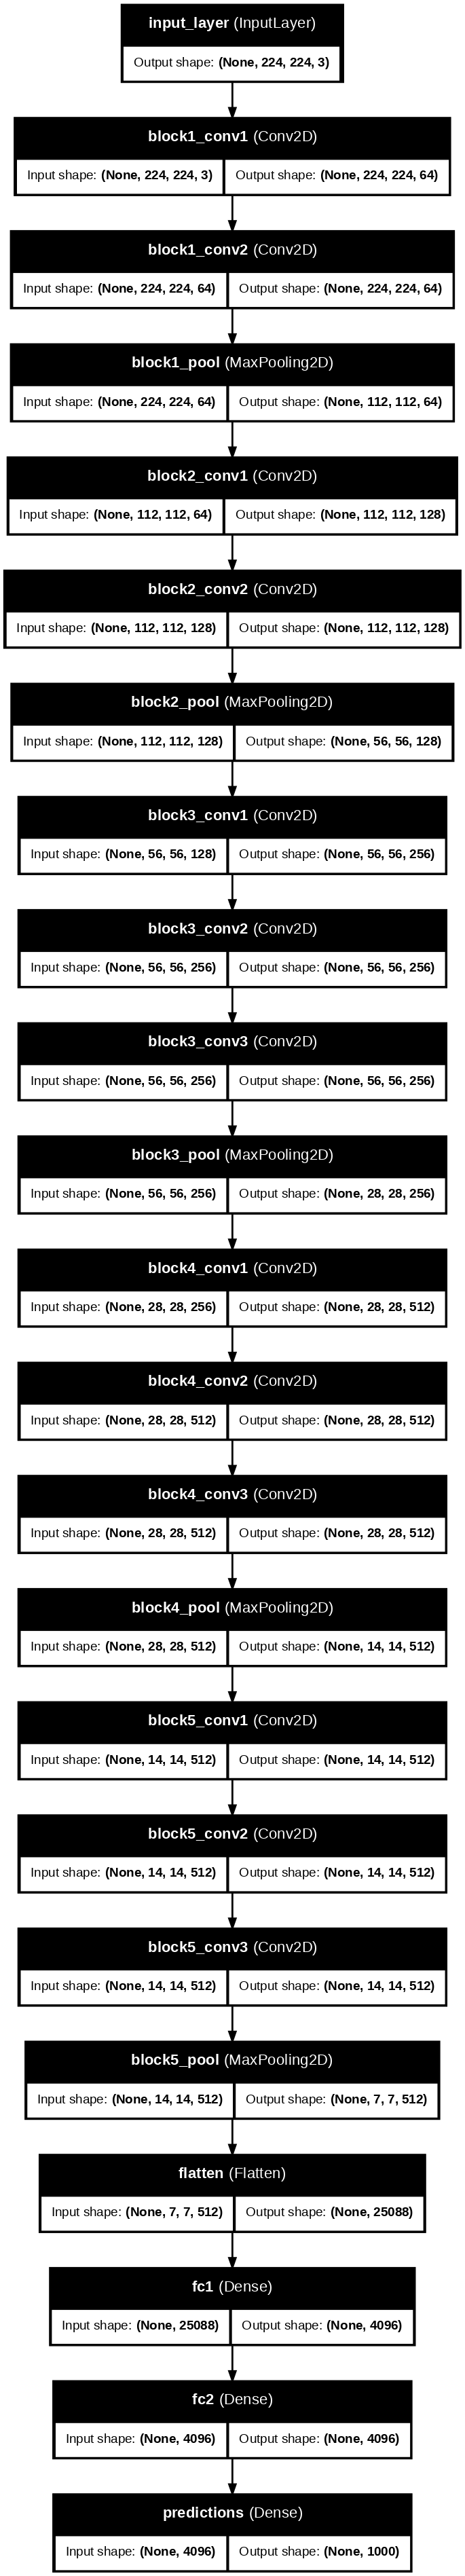

In [17]:
# Add dpi and expand_nested for clearer and more detailed diagrams
plot_model(vgg16_model, to_file='vgg16_model.png',
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True,
           dpi=100)

## Transfer

### Base

In [18]:
# Load VGG16 pre-trained on ImageNet, excluding the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Freeze the layers of the VGG16 base
for layer in vgg16_base.layers:
    layer.trainable = False

### NEW Fully Connected

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [21]:
# Create a new model on top of the VGG16 base
transfer_model = Sequential()
transfer_model.add(vgg16_base)
transfer_model.add(Flatten())
transfer_model.add(Dense(1024, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(256, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(1, activation='sigmoid'))

In [22]:
# Compile the new model
transfer_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [23]:
transfer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,062,209 (156.64 MB)

 Trainable params: 26,347,521 (100.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
transfer_model.fit(train_generator,
                   epochs=2,
                   validation_data=validation_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
 83/154 ━━━━━━━━━━━━━━━━━━━━ 37s 525ms/step - accuracy: 0.5666 - loss: 2.3491

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 133s 749ms/step - accuracy: 0.6278 - loss: 1.8462 - val_accuracy: 0.9592 - val_loss: 0.1464
Epoch 2/2
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 534ms/step - accuracy: 0.8801 - loss: 0.2722 - val_accuracy: 0.9724 - val_loss: 0.1055


# Deployment


In [25]:
transfer_model.save('myModel.keras')

# VGG - 19

In [26]:

from tensorflow.keras.applications import VGG19

vgg19_model = VGG19(weights='imagenet')


574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
